In [1]:
using CSV
using DataFrames
using Flux
using HypothesisTests
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Tables

using BSON: @save
using BSON: @load

include("../helpers.jl")
include("../stats.jl")

updatescoresdict! (generic function with 1 method)

In [2]:
train_new_model = true

true

## Edit before running on new data

In [3]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [4]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [5]:
x_df = decorrelatedvars(x_df);
x_df, _ = minmaxscaledf(x_df);
y_df, y_scalers = minmaxscaledf(y_df);

(217293×6 DataFrame
    Row │ OBJ1        OBJ2        OBJ3       OBJ4       OBJ5       OBJ6       
        │ Any         Any         Any        Any        Any        Any        
────────┼─────────────────────────────────────────────────────────────────────
      1 │ 0.826477    -0.5        -0.634009  -0.894922  0.304231   -0.0885951
      2 │ 0.860978    -0.77439    -0.571843  -0.896336  -0.398366  -0.148115
      3 │ 0.415535    -0.347561   -0.740977  -0.901578  -0.283542  -0.697112
      4 │ -0.687251   0.304878    -0.152112  -0.989696  -0.844419  -0.91072
      5 │ 0.319384    -0.195122   -0.876751  -0.909171  -0.52974   -0.261674
      6 │ 0.552516    0.292683    -0.525845  -0.862149  0.382228   -0.182966
      7 │ 0.306727    -0.256098   -0.105772  -0.942763  -0.638978  -0.560059
      8 │ -0.0482801  0.237805    -0.823864  -0.890797  -0.100238  -0.0290749
      9 │ 0.0423599   0.189025    -0.331322  -0.960631  -0.521258  -0.634655
     10 │ 0.909564    0.20122     -0.360412  -0.9

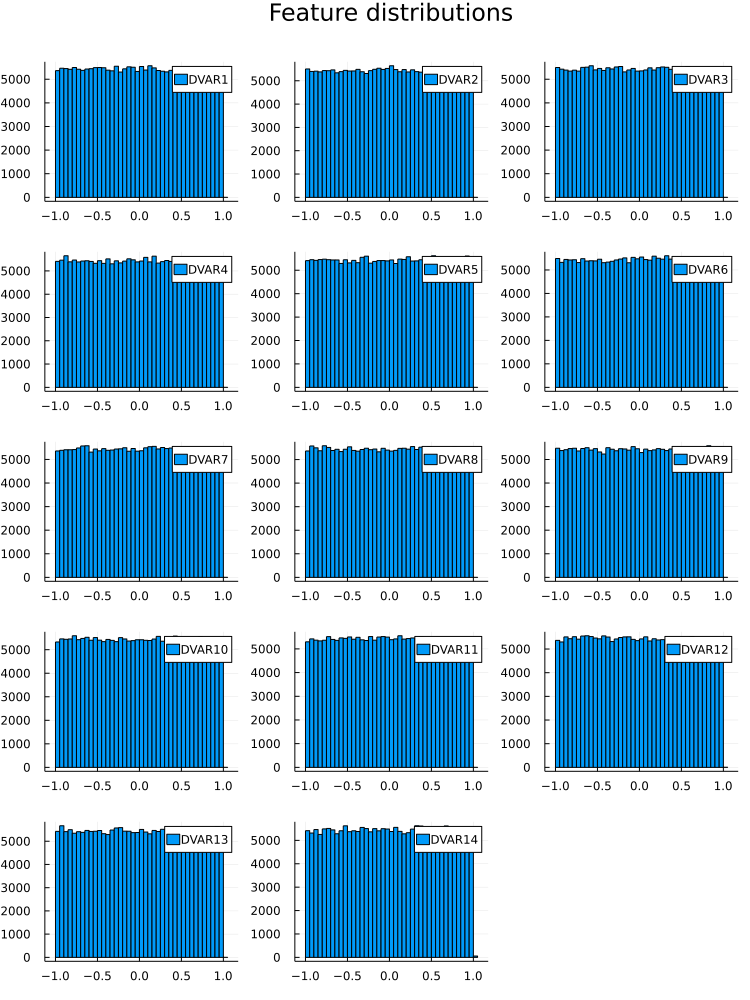

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Feature distributions")

In [7]:
x_train_df, x_test_df, y_train_df, y_test_df = traintestsplit(x_df, y_df; read_in=true, path="../indexes/")

x_train = Float64.(Matrix(x_train_df));
x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df));
y_test = Float64.(Matrix(y_test_df));

- Using preexisting train and test sets


In [8]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [9]:
# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 100, x->σ.(x)),
        (Dense(100, 100, x->σ.(x)) for _ in 1:5)...,
        Dense(100, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [10]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [11]:
# training, otherwise loading
if train_new_model
    m = neuralnetwork()
    optimizer = ADAM()
    loss(x, y) = Flux.mse(m(x), y)

    # training
    n_epochs = 2500
    training_losses = Float32[]
    epochs = Int32[]
    training_times = Float32[]

    for epoch in 1:n_epochs
        print("epoch $epoch,")
        start_time = time()
        Flux.train!(loss, Flux.params(m), data_loader, optimizer)
        end_time = time()
        push!(epochs, epoch)
        l = 0.
        for d in data_loader
            l += loss(d...)
        end
        println(" loss=$l")
        push!(training_losses, l)
        push!(training_times, Float32(end_time - start_time))
    end
    
    # @save "trained_nn.bson" m
    # CSV.write("train_indexes.csv",  Tables.table(train_indexes), writeheader=false)
    # CSV.write("test_indexes.csv", Tables.table(test_indexes), writeheader=false)
else
    @load "trained_nn.bson" m
end

epoch 1, loss=14.622557946631941
epoch 2, loss=5.517922120485171
epoch 3, loss=4.835901348920221
epoch 4, loss=3.299296066562454
epoch 5, loss=2.2515584067190617
epoch 6, loss=1.990658121560852
epoch 7, loss=1.8389465597243206
epoch 8, loss=1.8052024326799478
epoch 9, loss=1.7393441454923688
epoch 10, loss=1.7389028556680224
epoch 11, loss=1.7453268434099694
epoch 12, loss=1.6424088162783415
epoch 13, loss=1.6292066011572182
epoch 14, loss=1.5761416539148836
epoch 15, loss=1.546437403276595
epoch 16, loss=1.5096509713715611
epoch 17, loss=1.4820565976517774
epoch 18, loss=1.5093052112242296
epoch 19, loss=1.4386348286090664
epoch 20, loss=1.4338965370390824
epoch 21, loss=1.4152724289935827
epoch 22, loss=1.45764480986981
epoch 23, loss=1.3821479080088788
epoch 24, loss=1.3584074830321753
epoch 25, loss=1.3032006346371803
epoch 26, loss=1.291069344996754
epoch 27, loss=1.2809873736147146
epoch 28, loss=1.2634695211507079
epoch 29, loss=1.3429726998564224
epoch 30, loss=1.23656381643301

epoch 239, loss=0.9498801469496531
epoch 240, loss=0.9299822913337039
epoch 241, loss=0.9184740204674353
epoch 242, loss=0.9325280115028327
epoch 243, loss=0.9235171052281901
epoch 244, loss=0.9279960522301814
epoch 245, loss=0.9177590342585425
epoch 246, loss=0.9372522109429124
epoch 247, loss=0.9318294777329478
epoch 248, loss=0.9544253714497749
epoch 249, loss=0.9199312353352405
epoch 250, loss=0.9331387823775336
epoch 251, loss=0.9286137099947058
epoch 252, loss=0.9172345371065208
epoch 253, loss=0.9445682186514631
epoch 254, loss=0.9212672799517483
epoch 255, loss=0.934300246063323
epoch 256, loss=0.9169007512491013
epoch 257, loss=0.921702613517994
epoch 258, loss=0.9132952160818867
epoch 259, loss=0.937353881247173
epoch 260, loss=0.9237713269067549
epoch 261, loss=0.9216505027118654
epoch 262, loss=0.9309336215895792
epoch 263, loss=0.9247664821306991
epoch 264, loss=0.9111957845691723
epoch 265, loss=0.9266541640128574
epoch 266, loss=0.9311501946538254
epoch 267, loss=0.93822

epoch 474, loss=0.8677964661784604
epoch 475, loss=0.8747858551623225
epoch 476, loss=0.897097179382532
epoch 477, loss=0.8724888803018749
epoch 478, loss=0.8694848504433236
epoch 479, loss=0.8700396619795384
epoch 480, loss=0.8659008795583492
epoch 481, loss=0.8699681393813509
epoch 482, loss=0.8673286742759255
epoch 483, loss=0.8730146414370484
epoch 484, loss=0.8666846483167037
epoch 485, loss=0.8760576589832536
epoch 486, loss=0.8736355305099515
epoch 487, loss=0.8958602445680316
epoch 488, loss=0.8657198837798431
epoch 489, loss=0.87796013100882
epoch 490, loss=0.8744603391457816
epoch 491, loss=0.8649772702752013
epoch 492, loss=0.8698604321986675
epoch 493, loss=0.8966231290547406
epoch 494, loss=0.8802966186384773
epoch 495, loss=0.8667365238071966
epoch 496, loss=0.8717210475101022
epoch 497, loss=0.8617287737876664
epoch 498, loss=0.879460682995432
epoch 499, loss=0.8662910161519974
epoch 500, loss=0.865939056557283
epoch 501, loss=0.8631823918208807
epoch 502, loss=0.8650261

epoch 709, loss=0.8489276032860795
epoch 710, loss=0.839753813971118
epoch 711, loss=0.8428504848152887
epoch 712, loss=0.8403887532389974
epoch 713, loss=0.8358854388695491
epoch 714, loss=0.83923436959853
epoch 715, loss=0.83194024994208
epoch 716, loss=0.8357113031604865
epoch 717, loss=0.8343639788978782
epoch 718, loss=0.8394615838186174
epoch 719, loss=0.8294110179947665
epoch 720, loss=0.837445669456457
epoch 721, loss=0.833372420101818
epoch 722, loss=0.8298533773340082
epoch 723, loss=0.8347307541891326
epoch 724, loss=0.8324743226243092
epoch 725, loss=0.8289580238324926
epoch 726, loss=0.8396439940394594
epoch 727, loss=0.8311367868371499
epoch 728, loss=0.8373422752559692
epoch 729, loss=0.8441733289467588
epoch 730, loss=0.83466173793008
epoch 731, loss=0.8388631739713537
epoch 732, loss=0.8333153176527469
epoch 733, loss=0.8298310653626249
epoch 734, loss=0.8308878720809167
epoch 735, loss=0.8383209323445011
epoch 736, loss=0.8340919907724094
epoch 737, loss=0.83234641113

epoch 944, loss=0.8099130350313585
epoch 945, loss=0.811855597619786
epoch 946, loss=0.8122663704243385
epoch 947, loss=0.8088185779159444
epoch 948, loss=0.8113306375481507
epoch 949, loss=0.8121094986584739
epoch 950, loss=0.8183148858362461
epoch 951, loss=0.8176952687020187
epoch 952, loss=0.8089753031699204
epoch 953, loss=0.8113954222222642
epoch 954, loss=0.8160533183037858
epoch 955, loss=0.8147260355325378
epoch 956, loss=0.8079349872342377
epoch 957, loss=0.8256256510687505
epoch 958, loss=0.8080033539910778
epoch 959, loss=0.809150021464855
epoch 960, loss=0.809678076103417
epoch 961, loss=0.8116545567856821
epoch 962, loss=0.8110928372994006
epoch 963, loss=0.811532076109241
epoch 964, loss=0.807900576492998
epoch 965, loss=0.8105806874737572
epoch 966, loss=0.8153817047128756
epoch 967, loss=0.8275214204532888
epoch 968, loss=0.809271590388272
epoch 969, loss=0.8116211083877715
epoch 970, loss=0.8093111857908963
epoch 971, loss=0.8049882069804103
epoch 972, loss=0.80673007

epoch 1174, loss=0.7905157378916469
epoch 1175, loss=0.7893845081892396
epoch 1176, loss=0.7937330682178451
epoch 1177, loss=0.799542957394444
epoch 1178, loss=0.8034151487377947
epoch 1179, loss=0.7936446324746963
epoch 1180, loss=0.7976617291858231
epoch 1181, loss=0.7940151864673511
epoch 1182, loss=0.7932765881207456
epoch 1183, loss=0.791830656129711
epoch 1184, loss=0.7991625198190839
epoch 1185, loss=0.7934138718147508
epoch 1186, loss=0.797888926438478
epoch 1187, loss=0.793885979970781
epoch 1188, loss=0.8009144789681855
epoch 1189, loss=0.7973501474605903
epoch 1190, loss=0.792581619742135
epoch 1191, loss=0.7896191839396195
epoch 1192, loss=0.7893401116873159
epoch 1193, loss=0.791771639608045
epoch 1194, loss=0.8010743329268121
epoch 1195, loss=0.7950033182678005
epoch 1196, loss=0.7957902397088044
epoch 1197, loss=0.7876919594198012
epoch 1198, loss=0.7911147809053418
epoch 1199, loss=0.7924721982892577
epoch 1200, loss=0.7940554030617896
epoch 1201, loss=0.790868621063052

epoch 1403, loss=0.7913201566800033
epoch 1404, loss=0.774814429532678
epoch 1405, loss=0.773044289361823
epoch 1406, loss=0.7780162568302328
epoch 1407, loss=0.7735287268924942
epoch 1408, loss=0.7790545868051135
epoch 1409, loss=0.7762090638101778
epoch 1410, loss=0.7745619135719164
epoch 1411, loss=0.7771841879886814
epoch 1412, loss=0.7751442053704907
epoch 1413, loss=0.7757748905373297
epoch 1414, loss=0.7818028712051074
epoch 1415, loss=0.7760450324108974
epoch 1416, loss=0.7837342340723731
epoch 1417, loss=0.7781471272038921
epoch 1418, loss=0.7735682299449049
epoch 1419, loss=0.7777235448856169
epoch 1420, loss=0.7766301454080125
epoch 1421, loss=0.7819521466066975
epoch 1422, loss=0.7772067087983678
epoch 1423, loss=0.7812629663354849
epoch 1424, loss=0.7740543211373991
epoch 1425, loss=0.7731841886738964
epoch 1426, loss=0.7741691185497683
epoch 1427, loss=0.7749261234831378
epoch 1428, loss=0.7926146949788917
epoch 1429, loss=0.775027485042038
epoch 1430, loss=0.774673736058

epoch 1631, loss=0.7645252540557441
epoch 1632, loss=0.7641543055222126
epoch 1633, loss=0.7593227743404066
epoch 1634, loss=0.7600700593051306
epoch 1635, loss=0.7635095439168855
epoch 1636, loss=0.7648541301830424
epoch 1637, loss=0.7592689892253508
epoch 1638, loss=0.7643021228246318
epoch 1639, loss=0.7593675216183455
epoch 1640, loss=0.7577062042260325
epoch 1641, loss=0.7602380086556042
epoch 1642, loss=0.7638530658677446
epoch 1643, loss=0.7698059816613694
epoch 1644, loss=0.7627698034038652
epoch 1645, loss=0.7644262496737648
epoch 1646, loss=0.75651337005022
epoch 1647, loss=0.7590176513425031
epoch 1648, loss=0.758799606751546
epoch 1649, loss=0.7679853838293352
epoch 1650, loss=0.7630667143896522
epoch 1651, loss=0.7580277440229706
epoch 1652, loss=0.7588288684847411
epoch 1653, loss=0.7603896661156369
epoch 1654, loss=0.7581880215352753
epoch 1655, loss=0.7577136249841837
epoch 1656, loss=0.7590708351694481
epoch 1657, loss=0.7535401600773377
epoch 1658, loss=0.757131548982

epoch 1859, loss=0.7454143627827705
epoch 1860, loss=0.7444453174461354
epoch 1861, loss=0.7423466949895501
epoch 1862, loss=0.745450434003683
epoch 1863, loss=0.7523258728038403
epoch 1864, loss=0.7421183208872555
epoch 1865, loss=0.7431837412645564
epoch 1866, loss=0.741349932711508
epoch 1867, loss=0.7427028255091548
epoch 1868, loss=0.7442802254616855
epoch 1869, loss=0.7422272464660072
epoch 1870, loss=0.7495767545783435
epoch 1871, loss=0.7450715939483519
epoch 1872, loss=0.7387437952221598
epoch 1873, loss=0.7436627439980346
epoch 1874, loss=0.7414871176943946
epoch 1875, loss=0.7420658793638362
epoch 1876, loss=0.747358638564869
epoch 1877, loss=0.7423001898332428
epoch 1878, loss=0.737632296438825
epoch 1879, loss=0.7441281519674369
epoch 1880, loss=0.7411261515506855
epoch 1881, loss=0.7518877280827467
epoch 1882, loss=0.742420576815075
epoch 1883, loss=0.7467807710714037
epoch 1884, loss=0.7433750239683459
epoch 1885, loss=0.742497065658545
epoch 1886, loss=0.739223102515524

epoch 2087, loss=0.723775551126831
epoch 2088, loss=0.7237359770585592
epoch 2089, loss=0.7223621216456005
epoch 2090, loss=0.7292307893324136
epoch 2091, loss=0.723851996012006
epoch 2092, loss=0.7242124562629941
epoch 2093, loss=0.7236688474501577
epoch 2094, loss=0.7222353315077594
epoch 2095, loss=0.72312391937669
epoch 2096, loss=0.7270298964206021
epoch 2097, loss=0.7323336729736969
epoch 2098, loss=0.7307873264429764
epoch 2099, loss=0.7261676297276324
epoch 2100, loss=0.7296659200108487
epoch 2101, loss=0.72260767696252
epoch 2102, loss=0.7231835968446084
epoch 2103, loss=0.7223626202331149
epoch 2104, loss=0.7235890319445376
epoch 2105, loss=0.7260077652555834
epoch 2106, loss=0.7290168371668055
epoch 2107, loss=0.7235602559817218
epoch 2108, loss=0.7198019732280875
epoch 2109, loss=0.7217287069411131
epoch 2110, loss=0.7223797520588016
epoch 2111, loss=0.725181478181234
epoch 2112, loss=0.7244062568572894
epoch 2113, loss=0.722791113499633
epoch 2114, loss=0.7219756493096526


epoch 2315, loss=0.7063337774786171
epoch 2316, loss=0.7100107251768007
epoch 2317, loss=0.7051765450164359
epoch 2318, loss=0.7084476246088351
epoch 2319, loss=0.7128909401983099
epoch 2320, loss=0.7062156003971238
epoch 2321, loss=0.7111560467027032
epoch 2322, loss=0.7070883154562809
epoch 2323, loss=0.707242402861475
epoch 2324, loss=0.7080530268095355
epoch 2325, loss=0.7069922146462008
epoch 2326, loss=0.7078701648131533
epoch 2327, loss=0.7052638683308455
epoch 2328, loss=0.711734803003213
epoch 2329, loss=0.7082507363868762
epoch 2330, loss=0.7098170875596003
epoch 2331, loss=0.707359953929949
epoch 2332, loss=0.7121267726688506
epoch 2333, loss=0.7058716964640477
epoch 2334, loss=0.7075328202553973
epoch 2335, loss=0.7081725250815688
epoch 2336, loss=0.70678546535517
epoch 2337, loss=0.7126159044123233
epoch 2338, loss=0.7089483562290394
epoch 2339, loss=0.70594751813016
epoch 2340, loss=0.7034102096383893
epoch 2341, loss=0.708450205290371
epoch 2342, loss=0.7042378225056277


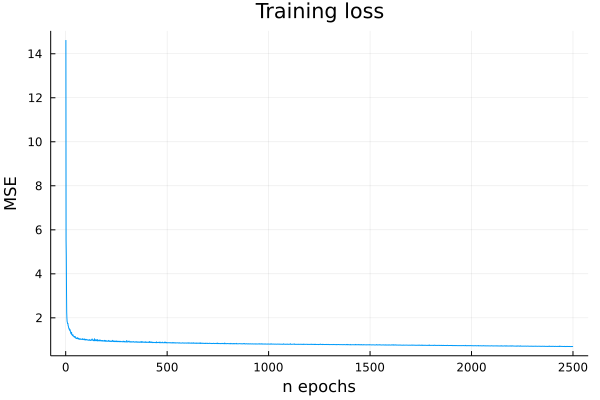

In [12]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [13]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [14]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.9353114746351164
r2 on test set: 0.9215639239314838


In [15]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [16]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.9353062471286653
adjustedr2 on test set: 0.9215385641230508


In [17]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.04226891808684331
mae on test set: 0.04581786632680336


In [18]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.01646364921640101
mae on test set for OBJ1: 0.018076748229267487
mae on training set for OBJ2: 0.0724384186225739
mae on test set for OBJ2: 0.07558902117314972
mae on training set for OBJ3: 0.010689148052416041
mae on test set for OBJ3: 0.011031249426190022
mae on training set for OBJ4: 0.0059522974233184155
mae on test set for OBJ4: 0.0060568373106376985
mae on training set for OBJ5: 0.07588826476629962
mae on test set for OBJ5: 0.08426324597528345
mae on training set for OBJ6: 0.0721817304400509
mae on test set for OBJ6: 0.0798900958462918


In [19]:
#=== redefine minmaxscaler for now ===#
function minmax_fit!(scaler, data)
    scaler.data_min = minimum(data); scaler.data_max = maximum(data)
end

function minmax_transform(scaler, data)
    [2*(d - scaler.data_min)/(scaler.data_max - scaler.data_min) - 1 for d in data]
end

function minmax_inverse_transform(scaler, data_scaled)
    [0.5*(scaler.data_max - scaler.data_min)*(d_s + 1) + scaler.data_min for d_s in data_scaled]
end

function minmax_fit_transform(data)
    scaler = MinMaxScaler(0., 0.)
    minmax_fit!(scaler, data)
    minmax_transform(scaler, data)
end

minmax_fit_transform (generic function with 1 method)

In [20]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

mape (generic function with 2 methods)

In [26]:
y_scalers

Dict{String, MinMaxScaler} with 6 entries:
  "OBJ4" => MinMaxScaler(0.00582, 1.34901)
  "OBJ6" => MinMaxScaler(0.00697, 0.10912)
  "OBJ2" => MinMaxScaler(0.0542, 0.087)
  "OBJ3" => MinMaxScaler(35.05, 386.37)
  "OBJ5" => MinMaxScaler(0.00731, 0.10398)
  "OBJ1" => MinMaxScaler(1.53, 99.5)

In [27]:
# mape for each response
for i in 1:y_dimension
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_train_trues_normalized = y_train[:, i]
    
    temp_test_preds_normalized = y_test_preds[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    # unnormalize
    y_scaler = y_scalers["OBJ$i"]
    
    temp_train_preds_original = minmax_inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_train_trues_original = minmax_inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_preds_original = minmax_inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_test_trues_original = minmax_inverse_transform(y_scaler, temp_test_trues_normalized)
    
    # println("MAPE on training set for OBJ$i: ", mape(temp_train_preds_original, temp_train_trues_original))
    println("MAPE on test set for OBJ$i: ", mape(temp_test_preds_original, temp_test_trues_original))
end

MAPE on test set for OBJ1: 0.016698612813092796
MAPE on test set for OBJ2: 0.018148223835749475
MAPE on test set for OBJ3: 0.016786900792064484
MAPE on test set for OBJ4: 0.07558608857598655
MAPE on test set for OBJ5: 0.11776483812104686
MAPE on test set for OBJ6: 0.1166060586863029


## Plotting / results

| Variable    | Name | MAPE: Me | MAPE: Paper |
| --------- | ---- | ---- | ----- |
| OBJ1  | Transmission  | 1.7% | 2.4% |
| OBJ2  | Output energy | 1.8% | 1.9% |
| OBJ3  | RFQ Length    | 1.3% | 2.0% |
| OBJ4  | Longitudinal $\epsilon$ | 4.8% | 8.2% |
| OBJ5  | $\epsilon_x$ | 11.7% | 12.8% | 
| OBJ6  | $\epsilon_y$ | 11.5% | 12.5% |

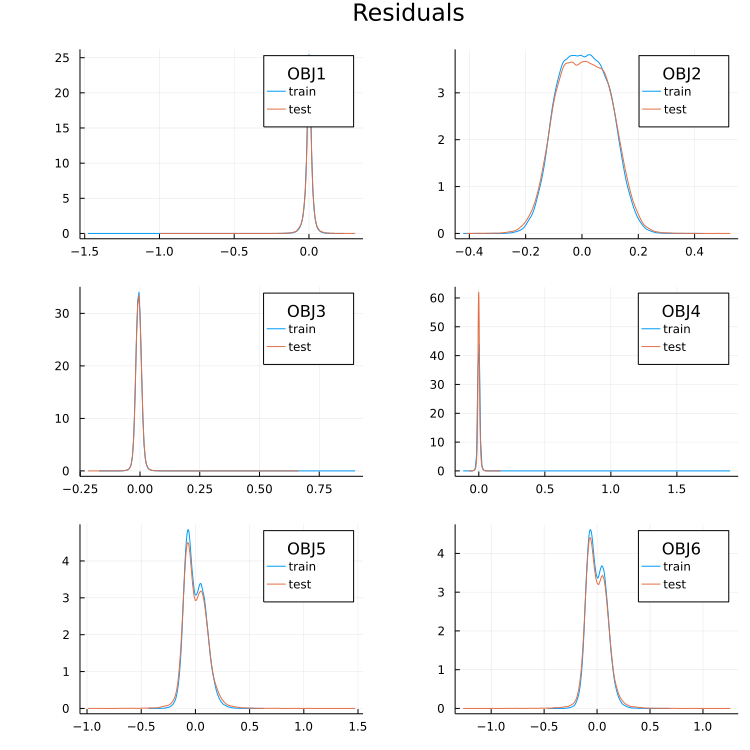

In [22]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

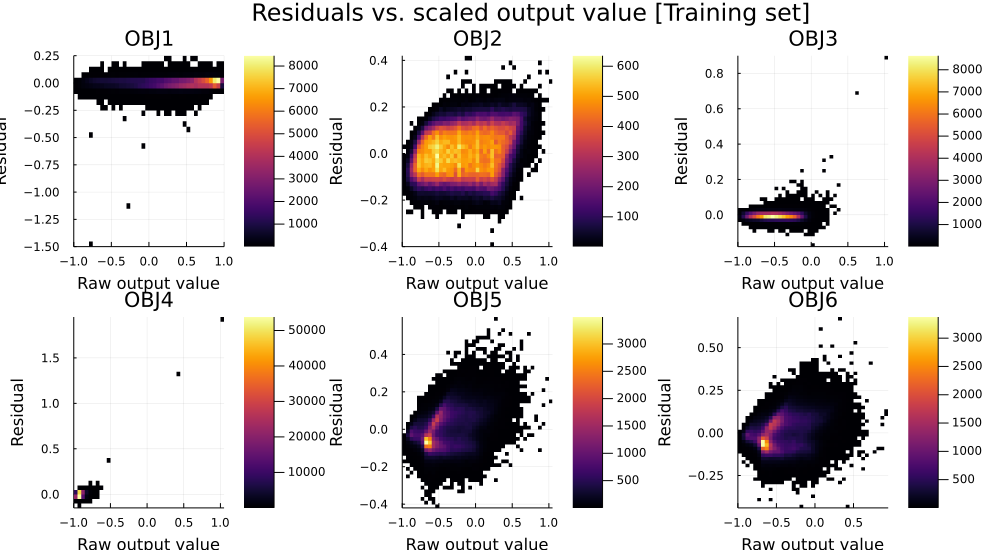

In [23]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

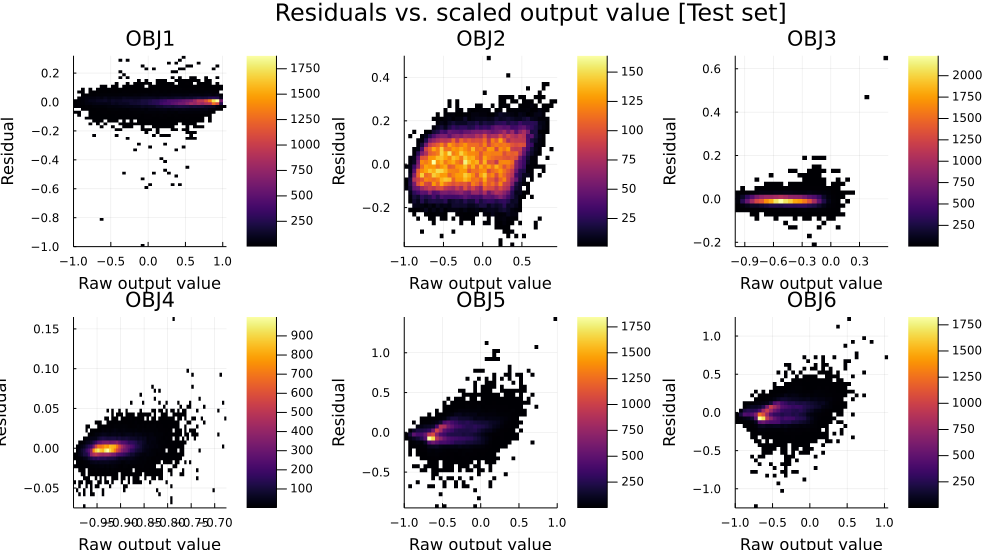

In [24]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")

How can we explain the two-band structure in the residuals of OBJ5 and OBJ6?

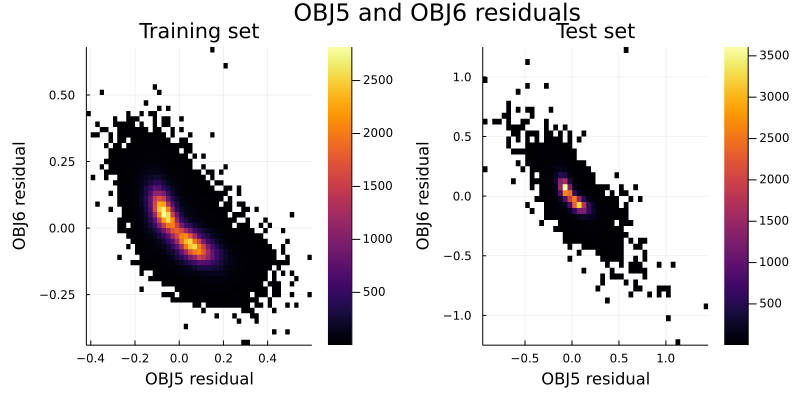

In [41]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    residuals_train[:, 5], residuals_train[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    residuals_test[:, 5], residuals_test[:, 6];
    xlabel="OBJ5 residual", ylabel="OBJ6 residual", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(800, 400), plot_title="OBJ5 and OBJ6 residuals",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

In [43]:
using Statistics;
println("Correlation between resids for 5 and 6 for train:")
println(Statistics.cor(residuals_train[:, 5], residuals_train[:, 6]))
println("Correlation between resids for 5 and 6 for test:")
println(Statistics.cor(residuals_test[:, 5], residuals_test[:, 6]))

Correlation between resids for 5 and 6 for train:
-0.7680495528272213
Correlation between resids for 5 and 6 for test:
-0.7720723467003151


In [50]:
using GLM;

fm = @formula(x6 ~ x5)
linearRegressor = lm(fm, DataFrame(residuals_train))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

x6 ~ 1 + x5

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error        t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.0025921  0.000133976   -19.35    <1e-82  -0.00285469  -0.00232951
x5           -0.731174   0.00146464   -499.22    <1e-99  -0.734045    -0.728304
─────────────────────────────────────────────────────────────────────────────────

In [51]:
r2(linearRegressor)

0.5899001155980967

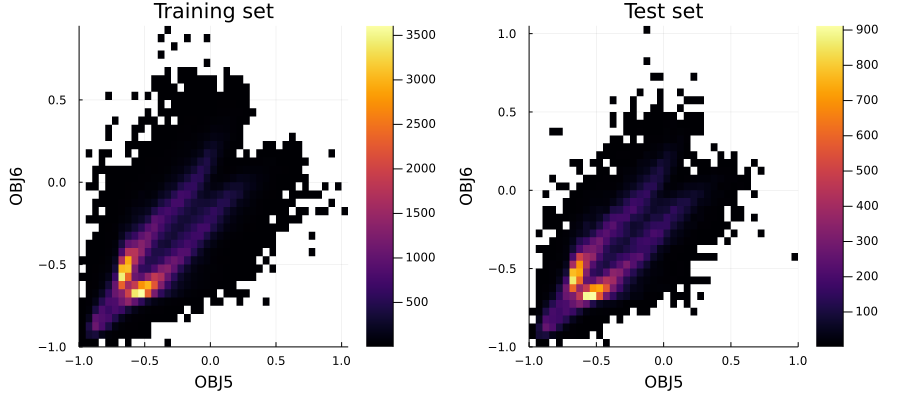

In [56]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    y_train[:, 5], y_train[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="train", legend=true,
    title="Training set", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    y_test[:, 5], y_test[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="test", legend=true,
    title="Test set", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)

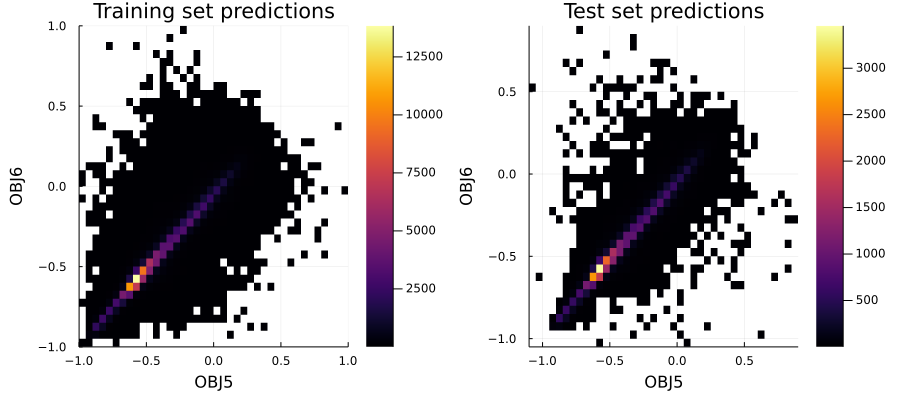

In [57]:
# residuals of OBJ5 and OBJ6 as a 2d hist
l = @layout [grid(1,2)]

subplots = []
sp_train = histogram2d(
    y_train_preds[:, 5], y_train_preds[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="train", legend=true,
    title="Training set predictions", bins=(60, 60)
)
push!(subplots, sp_train)

sp_test = histogram2d(
    y_test_preds[:, 5], y_test_preds[:, 6];
    xlabel="OBJ5", ylabel="OBJ6", label="test", legend=true,
    title="Test set predictions", bins=(60, 60)
)
push!(subplots, sp_test)

plot(subplots..., layout = l, size=(900, 400), plot_title="",
    bottom_margin = 5Plots.mm, left_margin=5Plots.mm)